# Bootstrap Distance Imposters

This method is novel, so as with all new things it should be taken with a grain of salt. One problem with GI (as discussed in the [GI Notebook](nux_imposters_ngram.ipynb)) is that it can be difficult to interpret at the high confidence end. This method extends the basic idea by measuring a complete _distance distribution_. In general, given a vector distance function $d(x,y)$ and some variables: $x$ an unknown text; $c_i \in C$ a set of candidate documents; and $y_j \in Y$ a set of imposter documents, GI estimates by boostrap the *single probability* that $min(d(x,C)) < min(d(x,Y))$ ('likelihood a candidate is closer than an imposter'). By contrast, this method records at each iteration $D \coloneqq min(d(x,Y)) - min(d(x,C))$ the _distance_ between the closest candidate and the closest imposter. For situations where $x$ is not by the candidate author we would expect $E[D] \approx 0$ (since the candidates are also imposters), whereas if the candidate is the true author the distance distribution will be centred around a positive number (distance to candidate tends to be less than distance to imposter). In situations of mistaken identity, when the true author is actually among the imposters, then $E[D]$ will be significantly below zero--something that is also not visible with GI. For those who desperately crave _p_-values, the probability mass that is less than zero represents the uncertainty.

This seems more (statistically) powerful in this particular application (not here, but in the [poetry analysis](nux_boot_poet.ipynb)), and provides results that are much more interpretable, since results that are simply "1" in GI (a candidate text was closest in every iteration) will now return full distributions, even though every difference > 0.

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import heapq

from numpy.typing import NDArray
from typing import Callable

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

from ruzicka.test_metrics import minmax

## Vectorizing

Here we use the same configuration as for the [GI Notebook](nux_imposters_ngram.ipynb), i.e. 5000 most-frequent 2-,3-, and 4-grams, with _z_-scaling.

In [3]:
vec_ngrams_std = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(2, 4),
        max_features=5000,
    ),
    StandardScaler(
        with_mean=False
    ),  # never centre frequency data for the minmax metric!
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
    Normalizer(),
)

In [4]:
vecs = pd.read_csv("elegy_corpus.csv", index_col=0)
non_elegy_vecs = pd.read_csv("non_elegy_corpus.csv", index_col=0)

## Corpus

See [this notebook](build_corpus.ipynb) for corpus creation details. I use Augustan 'short elegy' as elsewhere, but no poem that is less than twenty lines. In addition, I include 200 samples with length $\sim N(80,20)$ drawn from assorted works of epic hexameter.

In [5]:
corpus = pd.concat([vecs, non_elegy_vecs])

In [6]:
test_corpus = corpus[corpus.Author != "ps-Ovid"]
test_corpus = test_corpus[test_corpus.LEN >= 20]
test_corpus

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
195,V.Flaccus,195-Argonautica,195-Argonautica,98,si pelopis duros prior hippodamia labores\neks...
196,Lucretius,196-DRN,196-DRN,93,dekiderunt kwo_kwet in talis wenere meatus\nkw...
197,Horace,197-Hor.,197-Hor. Sat.,94,eksirem plures kalones atkwe kaballi\npaskendi...
198,Vergil,198-Aeneid,198-Aeneid,106,in lukem genito_ramyko dedit et fake praenjas\...


In [7]:
lenc = LabelEncoder()
labels = lenc.fit_transform(test_corpus.Author)

In [8]:
X = vec_ngrams_std.fit_transform(test_corpus.Chunk)
y = np.array(lenc.fit_transform(test_corpus.Author))

In [9]:
problems = corpus[corpus.Author == "ps-Ovid"]
probs_X = vec_ngrams_std.transform(problems.Chunk)
problem_dict = dict(zip(problems.Poem, probs_X))

## BDI Implementation

Vectorisation and Distance are both abstract.

In [10]:
def bootstrap_imposters(
    test_vec: NDArray[float],
    X: NDArray[NDArray[float]],
    y: NDArray[int],
    cand_idx: int,
    n: int,
    pct: float,
    dist_fn: Callable[[NDArray[float], NDArray[float]], float],
    method: str = "random",
    rng: np.random.Generator = np.random.default_rng(),
) -> list[float]:
    # X at the row indices where y matches the condition
    candidates = X[(y == cand_idx).nonzero()]
    others = X[(y != cand_idx).nonzero()]
    differences: list[float] = []
    cand_samps: NDArray[float] = []
    other_samps: NDArray[float] = []
    if method == "random":
        # choose n random row indices with replacement, all columns. This will
        # still work if n > num_candidates because it will oversample.
        cand_samps = candidates[rng.choice(candidates.shape[0], n, replace=True), :]
        other_samps = others[rng.choice(others.shape[0], n, replace=True), :]

    # At each bootstrap iteration we choose a different feature subset
    for i in range(n):
        # from 1d vectors, choose (pct * width_of_X) random column indices (no
        # replacement)
        ridx = rng.choice(X.shape[1], int(X.shape[1] * pct), replace=False)

        # compare the test vector to one in-sample and one outsample (with
        # bootstrap columns), then record the difference of distances
        if method == "random":
            in_dist = dist_fn(test_vec[ridx], cand_samps[i][ridx])
            out_dist = dist_fn(test_vec[ridx], other_samps[i][ridx])
            differences.append(out_dist - in_dist)

        # compare the test vector to the closest in-sample and out-sample, then
        # record the difference of distances (like vanilla Kestemont GI)
        elif method == "closest":
            in_dists = [
                dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
            ]
            out_dists = [
                dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
            ]
            differences.append(min(out_dists) - min(in_dists))

        # compare the test vector to the closest in-sample and out-sample, then
        # record the scaled difference of distances for the smallest 3 (like
        # Kestemont GI with Eder Boostrap Consensus Tree stye ranking)
        elif method == "ranked":
            in_dists = [
                dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
            ]
            out_dists = [
                dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
            ]
            # faster than sorting and slicing
            top_in = heapq.nsmallest(3, in_dists)
            top_out = heapq.nsmallest(3, out_dists)
            d = 0
            for n in range(3):
                # smallest distances are unscaled, seccond is halved, etc
                d += (top_out[n] - top_in[n]) / (n + 1)
            differences.append(d)
        else:
            raise ValueError(
                f"Unsupported method {method}, valid are: random, closest, ranked"
            )
    return differences

# Results

As with the [GI Notebook](nux_imposters_ngram.ipynb), all of the problem texts are shown as closer to Ovid than to any of the imposter authors, in lexico-grammatical style.

In [11]:
results = {}
for poem, vec in problem_dict.items():
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        lenc.transform(["Ovid"])[0],
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
    )
    results[poem] = bs

df = pd.DataFrame(results)

### Quick Plotting

Just an example of how to quickly plot the results straight from a `pandas.DataFrame`. Here we use Kernel Density Estimation to create smooth density estimates from the point data.

<AxesSubplot:title={'center':'Bootstrap Match Strength vs Ovid'}, ylabel='Density'>

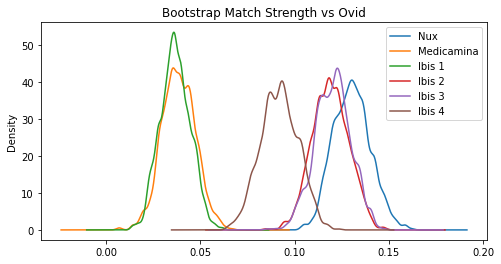

In [12]:
df[df.columns[~df.columns.str.startswith("Consolatio")]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(8, 4),
    title="Bootstrap Match Strength vs Ovid",
)

<AxesSubplot:title={'center':'Bootstrap Match Strength vs Ovid'}, ylabel='Density'>

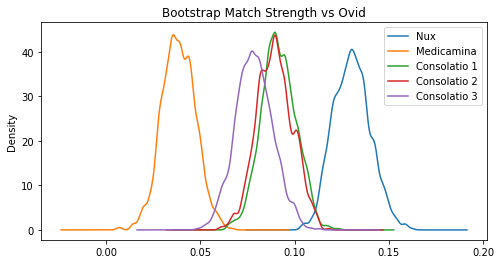

In [13]:
df[df.columns[~df.columns.str.startswith("Ibis")]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(8, 4),
    title="Bootstrap Match Strength vs Ovid",
)

### Summary Statistics

It is better to look at the full results (which, for each text, is a distribution), but the 'uncertainty' can be interpreted as the probability mass that is below 0 (bootstrap iterations where the closest candidate was _further_ than the cloest imposter).

In [14]:
for poem, ary in results.items():
    print(f"{poem:<15}> Percent doubt: {sp.stats.percentileofscore(ary, 0):.2%}")

Nux            > Percent doubt: 0.00%
Medicamina     > Percent doubt: 0.00%
Consolatio 1   > Percent doubt: 0.00%
Consolatio 2   > Percent doubt: 0.00%
Consolatio 3   > Percent doubt: 0.00%
Ibis 1         > Percent doubt: 0.00%
Ibis 2         > Percent doubt: 0.00%
Ibis 3         > Percent doubt: 0.00%
Ibis 4         > Percent doubt: 0.00%


## Production Figure

In [19]:
%load_ext rpy2.ipython

In [22]:
# for ggplot for this kind of plot it is easier to have 'long' tables, so we
# melt the dataframe so each observation for each text is a 'variable'. We add a
# column just so we can highlight the _Consolatio_ in a different colour.

dff = df.T
dff.reset_index(inplace=True)
tst = dff.melt(id_vars=["index"])
tst["cons"] = tst["index"].str.startswith("Cons")
tst.head()

,index,variable,value,cons
0,Nux,0,0.128997,False
1,Medicamina,0,0.035185,False
2,Consolatio 1,0,0.086219,True
3,Consolatio 2,0,0.074263,True
4,Consolatio 3,0,0.064741,True


Picking joint bandwidth of 0.00211


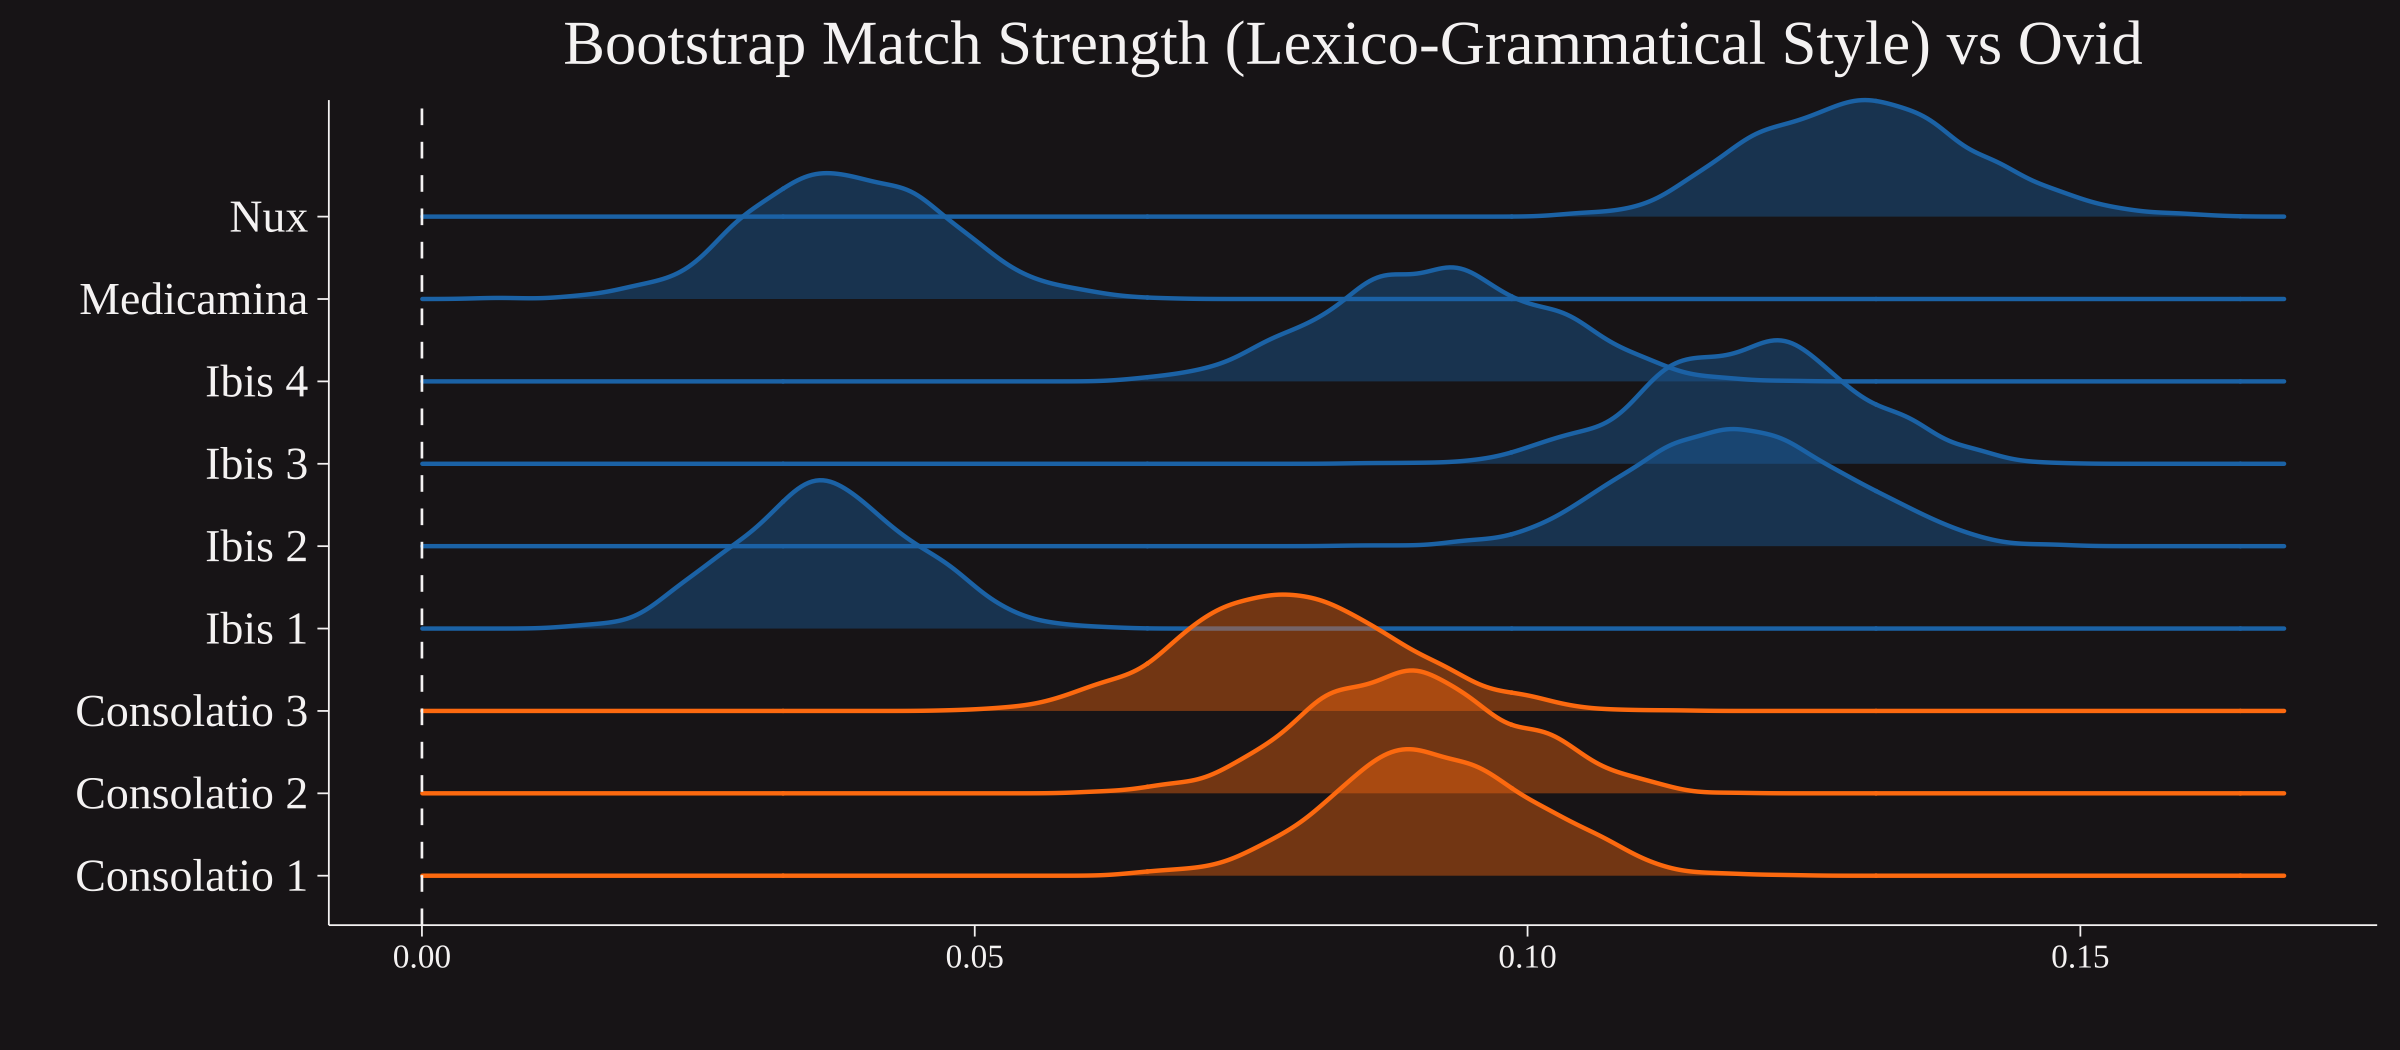

In [23]:
%%R -i tst -h 3.5 -w 8 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
font_add_google("Tinos", "fnt")
showtext_auto()

plt <- "ggsci::category10_d3"
bgcol <- '#1e1a1d'
fgcol <- '#f6f5f5'

ggplot(data=tst,aes(value,y=index,fill=cons,color=cons)) +
coord_cartesian(clip = "off") +

ggridges::stat_density_ridges(
    quantile_lines = FALSE, quantiles = 2, 
    alpha = .4, size = 0.5,
) +
geom_vline(xintercept=0, colour=fgcol, linetype='dashed', size=0.3) +
scale_y_discrete() +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Match Strength (Lexico-Grammatical Style) vs Ovid") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(size=0.2,color=fgcol),
    axis.line.y=element_line(size=0.2,color=fgcol),
    axis.ticks.x=element_line(size=0.2,color=fgcol),
    axis.ticks.y=element_line(size=0.2,color=fgcol),
    axis.text.x=element_text(size=8, family="fnt", color=fgcol),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)

# fn <- "../paper/figures/bootstrap_lexical.pdf"
# ggsave(fn, dpi=600, width=8, height=3.5, device=cairo_pdf)
